# Analyzing Hygiene of The Restaurant in NYC

#### A project for 15-688 course by: Yuan Qin (yuanq), Hanqi He(hanqih)

## Introduction

When eating outside, food hygiene is always a great concern. It is important that the restaurants meet the hygiene standards. In this project, we first analyze the NYC restaurant inspection data. Then, we incorporate it with business and review data from Yelp, hoping to use such external information to predict inspection score. This prediction problem is meaningful as it can help the health inspect institutions to allocate resources efficiently to restaurants that are likely to have higher score (higher score means worse hyginene condition), and to improve food hygiene. Also, such predicted score may be added to Yelp app.

Following is the outline of the report:

* [NYC restaurant inspection data](#NYC-restaurant-inspection-data)
    * [Importing and cleaning data](#Importing-and-cleaning-data)
    * [Exploratory data analysis](#Exploratory-data-analysis)
    * [Association Analysis](#Association-Analysis)
* [Yelp Data](#Yelp-Data)
    * [Business Information Data](#Business-Information-Data)
    * [Review Data](#Review-Data)
* [Predictive Analysis](#Predictive-Analysis)
    * [Data Merge](#Data-Merge)
    * [Exploratary Analysis](#Exploratary-Analysis)
    * [Lasso Regression](#Lasso-Regression)
    * [Random Forest](#Lasso-Regression)
    * [Light GBM](#Light-GBM)
    * [Light GBM on Review Text Data](#Light-GBM-on-Review-Text-Data)
* [Summary](#Summary)
* [Future Work](#Future-Work)   
    

## NYC restaurant inspection data

NYC's Department of Health and Mental Hygiene conducts unannounced inspections of restaurants every year, and we use their inspection result data, which is publicly available at [here](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59). 

The data dictionary and introduction of the grading system can be found in [this page](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59/about) under part of attachements , which is useful to understand the data.

### Importing and cleaning data

#### Data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('./data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [3]:
data.shape

(373191, 18)

In [4]:
data.sort_values(['CAMIS','INSPECTION DATE']).head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
204018,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,02/09/2015,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,6.0,A,02/09/2015,04/30/2018,Cycle Inspection / Initial Inspection
93628,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,02/18/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,10.0,A,02/18/2016,04/30/2018,Cycle Inspection / Initial Inspection
129959,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,02/18/2016,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,10.0,A,02/18/2016,04/30/2018,Cycle Inspection / Initial Inspection
20024,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,7.0,A,05/18/2017,04/30/2018,Cycle Inspection / Initial Inspection
330856,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,7.0,A,05/18/2017,04/30/2018,Cycle Inspection / Initial Inspection


*Note: 'CAMIS' is the unique identifier for each restaurant, 'DBA' is restaurant name, and 'BORO' is the borough(Area).*

We can see that each row shows a certain violation found, together with a score and grade. Notice that the score and grade is given based on inspection date. So for one inspection associated with an inspection date, one restaurant can have multiple rows data, with same score and grade. The score and grade transfer standard can be found in the original document: 
* A score of less than 14 points on either initial or re-inspection results in an “A” grade
* On re-inspection, a score of 14-27 points means a restaurant receives both a “B” grade
* On re-inspection, a score of 28 or more points means a restaurant receives both a “C” grade
* When critical violations have not been corrected on re-inspection, a restaurant may receive an additional compliance inspection within one to two weeks, but these inspections do not contribute to a grade.

The lower the score, the better hygiene condition of the restaurant.


#### Data Clean

First, transform 'INSPECTION DATE' to datetime type.

In [5]:
data['INSPECTION DATE'] = pd.to_datetime(data['INSPECTION DATE'])

In [6]:
data['INSPECTION DATE'].describe()

count                  373191
unique                   1407
top       1900-01-01 00:00:00
freq                     1123
first     1900-01-01 00:00:00
last      2018-04-28 00:00:00
Name: INSPECTION DATE, dtype: object

The first date goes back to 1900, which is strange. Checking the data dictionary, it shows that "1900-01-01" is used to mark those restaurants that have not been inspected yet. So remove those rows.

In [7]:
data1 = data[data['INSPECTION DATE'] != '1900-01-01']

In [8]:
data1['INSPECTION DATE'].describe()

count                  372068
unique                   1406
top       2018-03-28 00:00:00
freq                      975
first     2012-04-05 00:00:00
last      2018-04-28 00:00:00
Name: INSPECTION DATE, dtype: object

Now, the data is from 2012-04-25 to 2018-04-28.

Also, according to the grading system introduction, there are only four gradable inspection types. Since we are interested in the gradable inspections, we filter the data. Those types are: Cycle Inspection/Initial Inspection, Cycle Inspection/Re-Inspection, Pre-Permit (Operational)/Initial Inspection, Pre-Permit (Operational)/Re-Inspection.

In [9]:
gradable = ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection',
           'Pre-permit (Operational) / Re-inspection', 'Pre-permit (Operational) / Initial Inspection']
index = np.where(data1['INSPECTION TYPE'].apply(lambda x: x in gradable)==True)[0]
data1 = data1.iloc[index, :]

In [10]:
data1.shape

(341461, 18)

In [11]:
# check missing data information
missing_data = data1.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data >0]
pd.DataFrame(missing_data, columns = ['#Missing Data'])

,#Missing Data
GRADE DATE,159790
GRADE,158160
VIOLATION DESCRIPTION,1368
VIOLATION CODE,932
BUILDING,142


There are huge number of missing data in the columns of grade and grade date. Referring again to the original document, it says that "There may also be cases where a grade card was given out but a record of that grade issuance is missing from the data system, and therefore missing from this dataset, even though the SCORE field is populated. Note that when initial inspections are adjudicated down to the A range, the absence of an accompanying grade associated with that inspection is correct, because the grade would not be assigned until the re-inspection is performed. "

For the purpose of this project, we care about the final confirmed grade, so only consider those rows having a grade.

In [12]:
index = np.where(data1['GRADE'].apply(lambda x: x in ['A', 'B', 'C'])==True)[0]
data2 = data1.iloc[index, :]

In [13]:
data2.shape

(178259, 18)

In [14]:
# check missing data information
missing_data = data2.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data >0]
pd.DataFrame(missing_data, columns = ['#Missing Data'])

,#Missing Data
VIOLATION DESCRIPTION,961
VIOLATION CODE,711
BUILDING,89


Violation code and violation description can be missing if there is no violation found. And for some specific violation code there is no violation description. 

### Exploratory data analysis

#### What are those violations about?

In [15]:
violation_text = data2.loc[:,['VIOLATION CODE', 'VIOLATION DESCRIPTION']]
violation_text.dropna(inplace = True)
violation_text.reset_index(drop = True, inplace = True)

In [16]:
# helper function to process the violation description, code referred 15688 Homework
import re 
import nltk
from collections import Counter
import string
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    stopwords=nltk.corpus.stopwords.words('english')
    t0 = text.lower()  
    s = re.escape(string.punctuation)
    final = "["+s+"]"
    no = "([^" +s+"])"
    no1 = no +"\'" +no
    t1 = re.sub("'s","",t0) 
    t2 = re.sub(no1,r"\1\2",t1)
    t5 = re.sub(final," ",t2)
    
    tokens = nltk.word_tokenize(t5)
    tokens = [str(t) for t in tokens if str(t) not in stopwords]
    result = []
    for t in tokens:
        result.append(lemmatizer.lemmatize(t))
    
    return result

In [17]:
text = violation_text['VIOLATION DESCRIPTION'].apply(lambda x: process(x))

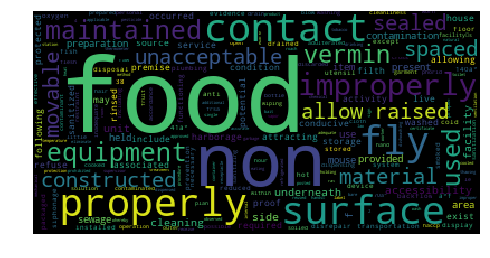

In [18]:
from wordcloud import WordCloud
counter = Counter()
for t in text:
    counter.update(t)
    
wc = WordCloud().generate_from_frequencies(counter)
plt.figure(figsize = (8,8))                       
plt.imshow(wc)
plt.axis('off')
plt.show()

From the wordcloud, we can see most common words in violation description include food, fly, properly, surface, ceaning, contmination,vermin,ect.. So we can infer that the violations may includes vermin found, food not stored properly, equipment surface not cleaned properly, etc.

#### Transform data representation

As mentioned before, currently, each row is for one violation. While for the purpose of analysis, we prefer to show each inspection in one row, and display the score, grade, and number of violations in that row.

In [19]:
data3 = data2.groupby(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE','GRADE','SCORE','INSPECTION TYPE'])
data4 = data3.count()

#drop the columns of grade date and record date, which is not useful
data5 = data4.loc[:, 'VIOLATION CODE']
data6 = pd.DataFrame(data5)
data6.reset_index(drop = False, inplace = True)

#rename column name
data6.columns = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'GRADE', 'SCORE', 'INSPECTION TYPE',
                 'VIOLATION COUNT']
data6.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,GRADE,SCORE,INSPECTION TYPE,VIOLATION COUNT
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2015-02-09,A,6.0,Cycle Inspection / Initial Inspection,1
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2016-02-18,A,10.0,Cycle Inspection / Initial Inspection,2
2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2017-05-18,A,7.0,Cycle Inspection / Initial Inspection,2
3,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2015-05-07,A,12.0,Cycle Inspection / Initial Inspection,2
4,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-04-30,A,13.0,Cycle Inspection / Re-inspection,4


In [20]:
data6.describe()

,CAMIS,ZIPCODE,SCORE,VIOLATION COUNT
count,7.793300e+04,77933.000000,77933.000000,77933.000000
mean,4.481912e+07,10668.271528,10.343962,2.277084
std,4.347761e+06,597.365484,5.578040,1.000415
min,3.007544e+07,10001.000000,-1.000000,0.000000
25%,4.124270e+07,10022.000000,7.000000,2.000000
50%,4.164040e+07,10467.000000,10.000000,2.000000
75%,5.001699e+07,11229.000000,12.000000,3.000000
max,5.007709e+07,11697.000000,94.000000,11.000000


It seems that there are some noise score data. Let's remove those having scores higher than 30, and violation count more than 5.

In [21]:
data6 = data6[data6['SCORE'] <= 30]
data6 = data6[data6['SCORE'] >= 0]
data6 = data6[data6['VIOLATION COUNT'] <= 5]

#### Does the inspection score differ across borough?

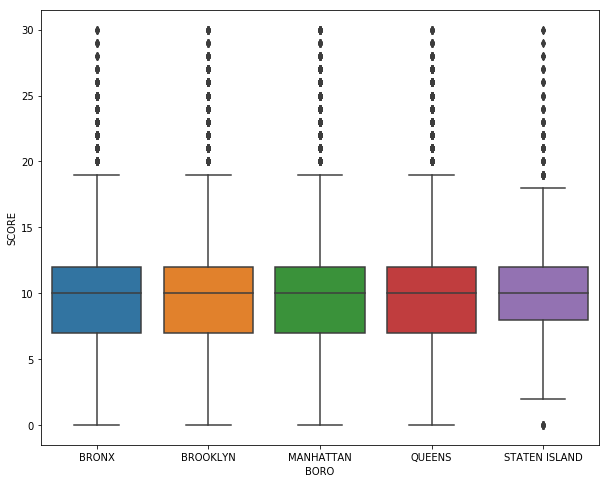

In [22]:
plt.figure(figsize = (10,8))  
sns.boxplot(data6['BORO'],data6['SCORE'])
plt.show()

There is no major differences in average restaurant scores. Median are all around 10, but restaurant in Staten Island have higher 25% quantile score.

#### Does the grade distribution differ across borough?

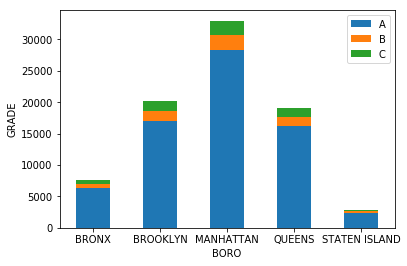

In [23]:
d1 = data6.loc[:,['BORO']].copy()
d1['A'] = data6['GRADE'].apply(lambda x: 1 if x == 'A' else 0)
d1['B'] = data6['GRADE'].apply(lambda x: 1 if x == 'B' else 0)
d1['C'] = data6['GRADE'].apply(lambda x: 1 if x == 'B' else 0)
d1 = d1.groupby('BORO').sum()

d1.plot.bar(stacked = True,ax = plt.gca())
plt.ylabel("GRADE")
plt.xticks(rotation=0)
plt.show()

The grade distribution did not differ a lot in different boroughs. Most restaurants get grade A, and a minority portion get grade B and C. Also, Manhattan has the largest number of restaurants, while Brooklyn is the 2nd, and Queens the 3rd.

 #### Does the number of violations differ across borough?

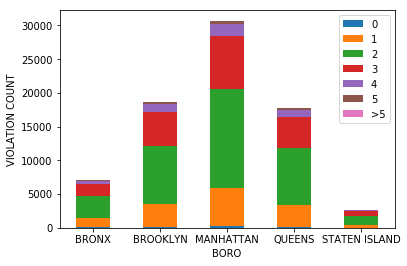

In [24]:
d2 = data6.loc[:,['BORO']].copy()
d2['0'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==0 else 0)
d2['1'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==1 else 0)
d2['2'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==2 else 0)
d2['3'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==3 else 0)
d2['4'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==4 else 0)
d2['5'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x ==5 else 0)
d2['>5'] = data6['VIOLATION COUNT'].apply(lambda x: 1 if x >5 else 0)
d2 = d2.groupby('BORO').sum()

d2.plot.bar(stacked = True,ax = plt.gca())
plt.ylabel("VIOLATION COUNT")
plt.xticks(rotation=0)
plt.show()

Again, not much different. 

Overall, the inspection result does not differ a lot across boroughs.

#### Does the score vary by cusine type?

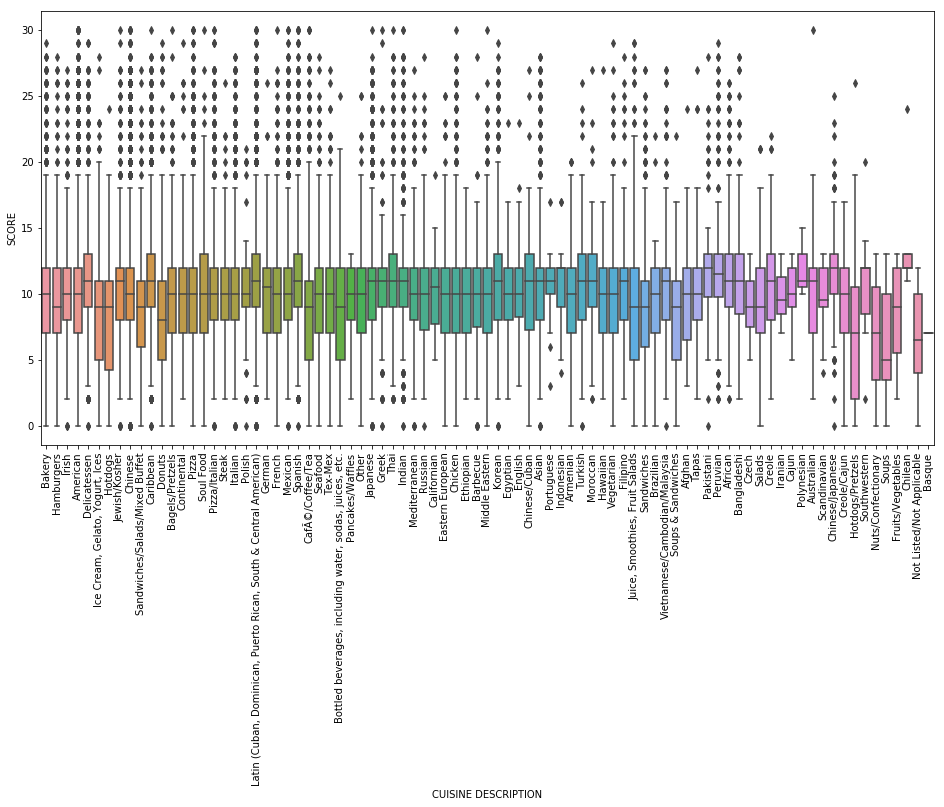

In [25]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = data6)
plt.xticks(rotation=90)
plt.show()

These categories have high median score: Chilean, Chinese/Japanese, Pakistani, Southwestern, Indonesian, Peruvian, Filipino, so be cautious when going to these restaurants. Also,these categories have relately low score and is a healthy choice: Soups, Basque, Nuts/Confectionary, Donuts, Sandwiches, Ice Cream, Salads, Hotdogs/Pretzels.

#### Does score vary by inspection type?

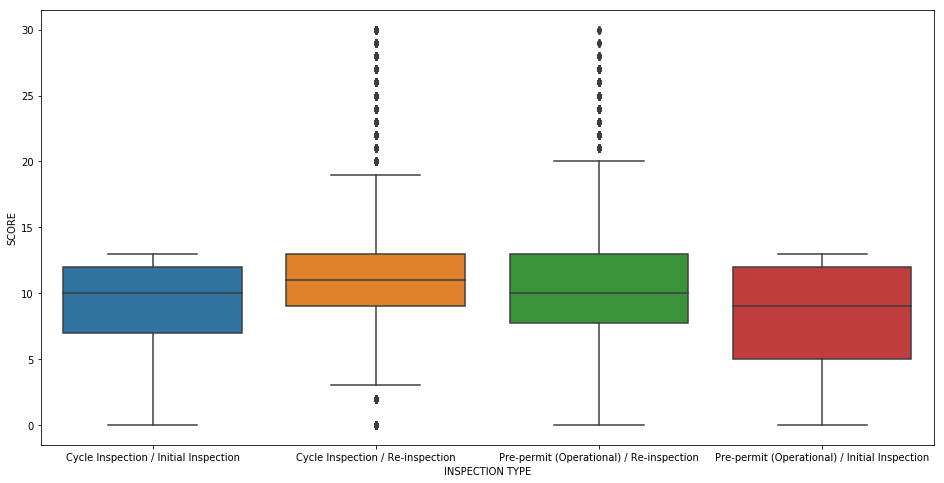

In [26]:
plt.figure(figsize = (16,8)) 
sns.boxplot(data6['INSPECTION TYPE'],data6['SCORE'])
plt.show()

The score is highest when doing Cycle Inspection/Re-inspection, and lowest in Pre-permit/Initial Inspection.

#### Does the grade and score vary over time?

We can extract meaningful time information, such as season, whether it is week day, day of week, etc.

In [27]:
def season(month):
    if month ==9 or month ==10 or month == 11:
        return 'fall'
    if month ==12 or month ==1 or month == 2:
        return 'winter'
    if month ==3 or month ==4 or month == 5:
        return 'spring'
    if month ==6 or month ==7 or month == 8:
        return 'summer'
    
def preprocess1(raw_data):
    data = raw_data.copy()
    
    #extract info from inspection date
    data['month'] = data['INSPECTION DATE'].map(lambda x: x.month)
    data['year'] = data['INSPECTION DATE'].map(lambda x: x.year)
    #'monday' is 0
    data['day_of_week'] = data['INSPECTION DATE'].map(lambda x: x.dayofweek)
   
    #season
    data['season'] = data['month'].map(lambda x: season(x))

    #is_week_day
    data['is_week_day'] = data['day_of_week'].map(lambda x: 1 if x!=5 and x!=6 else 0)

    return data

In [28]:
data7 = preprocess1(data6)

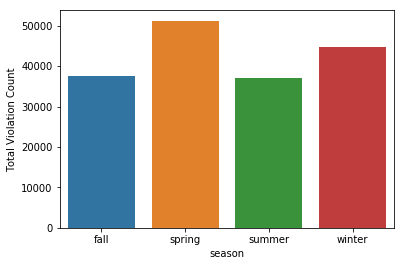

In [29]:
violation_sum = data7.groupby(['season']).sum()['VIOLATION COUNT']
sns.barplot(violation_sum.index,violation_sum.values)
plt.ylabel('Total Violation Count')
plt.show()

Spring and winter have more violations than in fall an summer.

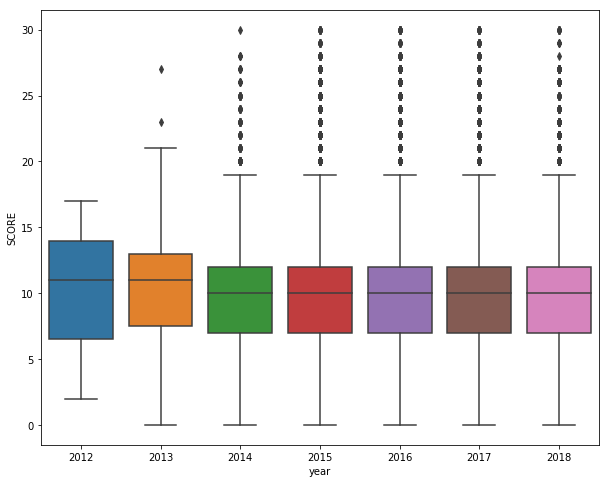

In [30]:
plt.figure(figsize = (10,8)) 
sns.boxplot(data7['year'],data7['SCORE'])
plt.show()

The grade decreases in 2014, and then remain stable.

### Association Analysis

We can use association rule to see whether some violations often happen together. 

First, transform data so that we know in each inspection, which violation code are recorded.

In [31]:
#generate basket data
data_AR = data2.loc[:, ['CAMIS','INSPECTION DATE','VIOLATION CODE']]
data_AR.dropna(inplace=True)
data_AR = data_AR.sort_values(['CAMIS','INSPECTION DATE'])

basket = data_AR.copy()
colnames = []
for code in data_AR['VIOLATION CODE'].unique():
    colnames.append(code)
    col = data_AR['VIOLATION CODE'].apply(lambda x: 1 if x==code else 0)
    basket[colnames[-1]] = col.values
    
basket = basket.groupby(['CAMIS','INSPECTION DATE']).sum().reset_index()

basket.drop(['CAMIS','INSPECTION DATE'],axis = 1, inplace = True)
print(basket.shape)
basket.head()

(77264, 65)


,06C,04L,08A,06D,10F,10B,04A,08C,10E,06B,...,06I,04I,05F,04F,03D,06H,02F,17A,07A,19A
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Now, we can use the apriori algorithom to find frequent item sets, and then find the association items. [mlxtend](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) package is used. 

In [32]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.sort_values(['lift'], ascending = False).reset_index(drop = True)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(04L, 10F)",(08A),0.032654,0.208622,0.028953,0.886643,4.249989,0.022140,6.981279
1,"(04L, 04N)",(08A),0.017977,0.208622,0.015725,0.874730,4.192887,0.011975,6.317376
2,"(04L, 10B)",(08A),0.018094,0.208622,0.015816,0.874106,4.189895,0.012041,6.286056
3,(04L),(08A),0.138926,0.208622,0.119085,0.857183,4.108777,0.090102,5.541192
4,(08A),(04L),0.208622,0.138926,0.119085,0.570817,4.108777,0.090102,2.006309
5,"(04N, 10B)",(08A),0.013603,0.208622,0.011545,0.848716,4.068190,0.008707,5.231056
6,"(10F, 04N)",(08A),0.021847,0.208622,0.018482,0.845972,4.055037,0.013924,5.137867
7,"(04M, 10F)",(08A),0.012127,0.208622,0.010251,0.845251,4.051582,0.007721,5.113937
8,"(08A, 10B)",(04L),0.028474,0.138926,0.015816,0.555455,3.998196,0.011860,1.936976
9,"(10F, 08A)",(04L),0.053233,0.138926,0.028953,0.543885,3.914920,0.021557,1.887844


After choosing min support at 0.01 and min confidence at 0.5, there are 13 association items found, all with lift >1. Take the third one as an example, it means that violation of code '04L' and '08A' often happen together. Out of 100 time the '04L' appears, 86 times the '08A' will happen together(confidence = 0.86). The probability that violation of "08A" will happen given that violation of "04L" happened is four times the probability that the violation of "08A" will happen in the whole dataset (lift = 4).

In [33]:
#Let‘s look at what does these two violation code means.
violation = violation_text.drop_duplicates().reset_index(drop = True)
index = np.where(violation['VIOLATION CODE'] == '08A')[0][0]
print('8A:',violation['VIOLATION DESCRIPTION'][index])
index = np.where(violation['VIOLATION CODE'] == '04L')[0][0]
violation['VIOLATION DESCRIPTION'][index]
print('4F:',violation['VIOLATION DESCRIPTION'][index])

8A: Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
4F: Evidence of mice or live mice present in facility's food and/or non-food areas.


The result makes sense as if there are mice, the vermin also likely to exists.

## Yelp Data

Yelp has huge amount of data about restaurants, which is generated by user reviews. We want to merge that with the NY restaurant inspection data, and see if such information can help predict the inspection results. 

### Business Information Data

We use Yelp API to get restaurant information data, including the price, rating, review count, location, etc. The API documentation can be found [here](https://www.yelp.com/developers/documentation/v3). We use the [phone search endpoint](https://www.yelp.com/developers/documentation/v3/business_search_phone), and use the phone information from the inspection data to match the restaurnat.

In [34]:
# these code are modified based on HW from 15-688 course
import io, time, json
import requests
from bs4 import BeautifulSoup

def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
    
def yelp_search(api_key, query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search phone

    Returns:
        final_result (list): list of businesses
    """
    
    headers = {
    "authorization": 'Bearer %s' % api_key, # for the yelp API 
    }
    
    params = {
        "phone":query,
        "categories": "restaurants"
    }
    
    response = requests.get('https://api.yelp.com/v3/businesses/search/phone',
                        headers=headers, params=params)
    result = response.json()
    
    final_result =[]
    
    if ('businesses' in result.keys() and len(result['businesses']) != 0):
        final_result += [i for i in result['businesses']]
        
    return final_result


In [35]:
#adjust phone format, in yelp dataset, the phone has prefix "+1"
data8 = data7.copy()
data8['PHONE1'] = data7['PHONE'].apply(lambda x: "+1"+x)
phone = data8['PHONE1'].unique()
data8.drop(['PHONE'], axis = 1,inplace = True)

The following code can be executed to get all the result. However, it is time consuming, and for each api key, Yelp only allows maximum 5000 times requests per day. Thus, we use several days to finish this process, and store the result file locally every time.

```python
api_key = read_api_key('yelp_key.txt')
final_result = []
for p in phone:
    time.sleep(0.2)
    final_result += yelp_search2(api_key, p)
```

In [36]:
# load the result file
json_data=open('final_result_all.txt').read()
final_result = json.loads(json_data)

In [37]:
# an sample output
final_result[2500]

{'alias': 'webster-cafe-and-diner-bronx',
 'categories': [{'alias': 'diners', 'title': 'Diners'},
  {'alias': 'cafes', 'title': 'Cafes'},
  {'alias': 'mexican', 'title': 'Mexican'}],
 'coordinates': {'latitude': 40.86729, 'longitude': -73.88391},
 'display_phone': '(718) 733-9634',
 'distance': 1984.463748654083,
 'id': '_aSe5iDV1Axe3jk9lHhb9g',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/Ge4UrjOWy3HbJd6ErjEhFQ/o.jpg',
 'is_closed': False,
 'location': {'address1': '2873 Webster Ave',
  'address2': '',
  'address3': '',
  'city': 'Bronx',
  'country': 'US',
  'display_address': ['2873 Webster Ave', 'Bronx, NY 10458'],
  'state': 'NY',
  'zip_code': '10458'},
 'name': 'Webster Cafe & Diner',
 'phone': '+17187339634',
 'price': '$',
 'rating': 3.5,
 'review_count': 62,
 'transactions': ['delivery', 'pickup'],
 'url': 'https://www.yelp.com/biz/webster-cafe-and-diner-bronx?adjust_creative=49llmLi0QPfblovrujyRVQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_sourc

#### Parse the result and store useful business information.

In [38]:
class yelp_info:
    def __init__(self, businesses):
        self.id = businesses['id']
        self.url = businesses['url']
        self.rating = businesses['rating']
        if ('price' in businesses.keys()):
            self.price = len(businesses['price'])
        else:
            self.price = -1
        self.review_count = businesses['review_count']
        self.phone = businesses['phone']
        self.zip = businesses['location']['zip_code']
        self.city = businesses['location']['city']
        self.lat = businesses['coordinates']['latitude']
        self.lon = businesses['coordinates']['longitude']
        self.state = businesses['location']['state']
        if(len(businesses['categories']) > 0):
            self.category = businesses['categories'][0]['alias']
        else:
            self.category = ""
        self.name = businesses['alias']

In [39]:
# Some phone match result is not what we look for. We use the state information to filter 
# out some wrong data.
phone_yelp_map = {}
for i in final_result:
    if (i['location']['state'] == 'NY'):
        phone_yelp_map[i['phone']] = yelp_info(i)

In [40]:
print("We finally match",len(phone_yelp_map),"restaurants using phone number.")

We finally match 15426 restaurants using phone number.


### Review Data

The review data from yelp also contains huge information that may be useful. Yelp provides a [Reviews endpoint](https://www.yelp.com/developers/documentation/v3/business_reviews). However, it will only return 3 reviews in 1 request. Considering the 5000 daily request limit, and the huge number of restaurants we have, it is not feasible. Therefore, we turn to do web scraping as we can get the url of the restaurant from the business information data we found in previous part.

In [41]:
def scrape_reviews(url):
    response = requests.get(url)
    html = response.content
    root = BeautifulSoup(html, "html.parser")
    
    result = []
    for div in root.find("div", class_ ="review-list").find("ul").find_all("div", class_= "review review--with-sidebar"):
        dic = {}
        content = div.find("div",class_= "review-content")
        dic['text'] = content.find("p").text.strip()
        dic['rating'] = (float) (content.find("div", class_ = "biz-rating biz-rating-large clearfix")\
        .find("div").find("div").attrs['title'][:3])
        #In order to increase the speed of web scraping, we comment the following codes
        #dic['date'] = content.find("span", class_ = "rating-qualifier").text.strip()
        #dic['review_id'] = div.attrs['data-review-id']
        #dic['user_id'] = div.attrs['data-signup-object'][8:]
        result.append(dic)
    return result

Web scrape is time-consuming. Due to the limitation of our computing power, we simply extract the most recent review data from the first page, but the above function can be easily modified to extract review from more pages. The following code can be used to get all the review data, but it is slow, so we use several days to finish this process, and store the result file locally every time.

```python
phone_review_map = {}
for p,v in phone_yelp_map.items():
    phone_review_map[p] = scrape_reviews(v.url)
```

In [42]:
#load the file from local
import pickle
phone_review_map = pickle.load( open( "phone_review_map.pkl", "rb" ) )

In [43]:
print(len(phone_review_map),"restaurants gets review data from web scrapping.")

15411 restaurants gets review data from web scrapping.


In [44]:
#sample output
phone_review_map['+17184443838'][:2]

[{'rating': 4.0,
  'text': "They used to prepare things more tastily in years past. Slowly falling off with quality and jacked prices being a lowly deli in this neighborhood. Though the soups are still banging. Won't stop, but honestly it's got the personal feel wanted."},
 {'rating': 2.0,
  'text': "7114 Avenue U, Brooklyn 11234(At E 71st St) good food but ripoff prices The store itself has prices that don't make sense example, a burger with blue cheese & bacon is $7.00 but with american cheese it's $8.75 + Tax so they charged $1.75 extra to switch from blue cheese to cheaper American Cheese ended up paying $25 for 2 bacon cheeseburgers and small fries and the burgers were not Deluxes. Never Again!!"}]

#### Parse the result and store useful review information

We parse the html to generate some new features about reviews, such as average review length, percentage of different ratings, etc.

In [45]:
# helper function to tokenize reviews
import re 
import nltk
import string
def tokenize(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    t0 = text.lower()  
    s = re.escape(string.punctuation)
    final = "["+s+"]"
    no = "([^" +s+"])"
    no1 = no +"\'" +no
    t1 = re.sub("'s","",t0) 
    t2 = re.sub(no1,r"\1\2",t1)
    t5 = re.sub(final," ",t2)
    
    tokens = nltk.word_tokenize(t5)
    tokens = [str(t) for t in tokens]
    result = []
    for t in tokens:
        result.append(lemmatizer.lemmatize(t))
    
    return result

#A class to store and create review information
class review_info:
    def __init__(self, reviews):
        self.count = len(reviews)
        self.ratings = [r['rating'] for r in reviews]
        self.text_list = [(r['text']) for r in reviews]
    
    # generate some useful features    
    def calculate(self):
        self.avg_rating = np.mean(self.ratings)
        
        #star distribution
        star1_count = 0
        star2_count = 0
        star3_count = 0
        star4_count = 0
        star5_count = 0
        for r in self.ratings:
            if r<=1:
                star1_count += 1
            elif r <= 2:
                star2_count +=1
            elif r<=3:
                star3_count +=1
            elif r<=4:
                star4_count +=1
            elif r<=5:
                star5_count +=1
        self.star1_percent = star1_count/self.count
        self.star2_percent = star2_count/self.count
        self.star3_percent = star3_count/self.count
        self.star4_percent = star4_count/self.count
        self.star5_percent = star5_count/self.count
        
        #avg_review_length
        review_length = [len(tokenize(r)) for r in self.text_list]
        self.avg_review_length = np.mean(review_length)
        
        #flatten reviews
        result = ''
        for t in self.text_list:
            result += t
        self.text_all = result

In [46]:
phone_review_info_map = {}
for p, r in phone_review_map.items():
    if (len(r) > 0):
        info = review_info(r)
        info.calculate()
        phone_review_info_map[p] = info

## Predictive Analysis

As we only get the most recent data of yelp, we only consider the most recent inspection for the matched restaurant to do the prediction.

In [47]:
#first order the data by CAMIS and inspection date
data8 = data8.sort_values(['CAMIS','INSPECTION DATE'])
data8.iloc[:10,:]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,GRADE,SCORE,INSPECTION TYPE,VIOLATION COUNT,month,year,day_of_week,season,is_week_day,PHONE1
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,Bakery,2015-02-09,A,6.0,Cycle Inspection / Initial Inspection,1,2,2015,0,winter,1,+17188924968
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,Bakery,2016-02-18,A,10.0,Cycle Inspection / Initial Inspection,2,2,2016,3,winter,1,+17188924968
2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,Bakery,2017-05-18,A,7.0,Cycle Inspection / Initial Inspection,2,5,2017,3,spring,1,+17188924968
3,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,2015-05-07,A,12.0,Cycle Inspection / Initial Inspection,2,5,2015,3,spring,1,+17182875005
4,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,2016-04-30,A,13.0,Cycle Inspection / Re-inspection,4,4,2016,5,spring,0,+17182875005
5,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,2016-10-27,A,11.0,Cycle Inspection / Re-inspection,2,10,2016,3,fall,1,+17182875005
6,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,2017-10-06,A,10.0,Cycle Inspection / Re-inspection,2,10,2017,4,fall,1,+17182875005
7,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,2018-03-13,A,12.0,Cycle Inspection / Initial Inspection,3,3,2018,1,spring,1,+17182875005
8,30191841,DJ REYNOLDS PUB AND RESTAURANT,MANHATTAN,351,WEST 57 STREET,10019.0,Irish,2015-09-21,A,8.0,Cycle Inspection / Re-inspection,2,9,2015,0,fall,1,+12122452912
9,30191841,DJ REYNOLDS PUB AND RESTAURANT,MANHATTAN,351,WEST 57 STREET,10019.0,Irish,2016-05-31,A,10.0,Cycle Inspection / Initial Inspection,2,5,2016,1,spring,1,+12122452912


In [48]:
#then group them, and get the last row of each group, 
#which will be the most recent inspection for that restaurant
data_recent = data8.groupby(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 
       'CUISINE DESCRIPTION','PHONE1']).last()
data_recent.reset_index(inplace = True)

In [49]:
data_recent.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,PHONE1,INSPECTION DATE,GRADE,SCORE,INSPECTION TYPE,VIOLATION COUNT,month,year,day_of_week,season,is_week_day
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,Bakery,+17188924968,2017-05-18,A,7.0,Cycle Inspection / Initial Inspection,2,5,2017,3,spring,1
1,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,Hamburgers,+17182875005,2018-03-13,A,12.0,Cycle Inspection / Initial Inspection,3,3,2018,1,spring,1
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,MANHATTAN,351,WEST 57 STREET,10019.0,Irish,+12122452912,2017-12-14,A,10.0,Cycle Inspection / Re-inspection,2,12,2017,3,winter,1
3,40356018,RIVIERA CATERERS,BROOKLYN,2780,STILLWELL AVENUE,11224.0,American,+17183723031,2017-07-20,A,13.0,Cycle Inspection / Initial Inspection,3,7,2017,3,summer,1
4,40356151,BRUNOS ON THE BOULEVARD,QUEENS,8825,ASTORIA BOULEVARD,11369.0,American,+17183350505,2017-08-19,A,10.0,Cycle Inspection / Initial Inspection,2,8,2017,5,summer,0


Now, it only contains the most recent inspection data for that restaurant.

### Data Merge

Merge NYU inspection data with yelp data.

In [50]:
# if no match, mark with -1 or ""
rating = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].rating if x in phone_yelp_map.keys() else -1)
url = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].url if x in phone_yelp_map.keys() else '')
yelp_id = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].id if x in phone_yelp_map.keys() else '')
price = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].price if x in phone_yelp_map.keys() else -1)
review_count = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].review_count if x in phone_yelp_map.keys() else -1)
zip_code_yelp = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].zip if x in phone_yelp_map.keys() else '')
city = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].city if x in phone_yelp_map.keys() else '')
lat = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].lat if x in phone_yelp_map.keys() else -1)
lon = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].lon if x in phone_yelp_map.keys() else -1)
name = data_recent['PHONE1'].apply(lambda x: phone_yelp_map[x].name if x in phone_yelp_map.keys() else '')
category = data_recent['PHONE1'].apply(lambda x: phone_yelp_map
                                       [x].category if x in phone_yelp_map.keys() else '')

avg_rating = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].avg_rating if x in phone_review_info_map.keys() else -1)
start1_percent = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].star1_percent if x in phone_review_info_map.keys() else -1)
start2_percent = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].star2_percent if x in phone_review_info_map.keys() else -1)
start3_percent = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].star3_percent if x in phone_review_info_map.keys() else -1)
start4_percent = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].star4_percent if x in phone_review_info_map.keys() else -1)
start5_percent = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].star5_percent if x in phone_review_info_map.keys() else -1)
avg_review_length = data_recent['PHONE1'].apply(lambda x: phone_review_info_map[x].avg_review_length if x in phone_review_info_map.keys() else -1)

In [51]:
data_recent_yelp = data_recent.assign(rating = rating.values, url = url.values, yelp_id = yelp_id.values,
                                     price = price.values, review_count = review_count.values,
                                     zip_code_yelp = zip_code_yelp.values, city = city.values,
                                     lat = lat.values, lon = lon.values, 
                                     name = name.values, category = category.values,
                                     avg_rating = avg_rating.values, start1_percent = start1_percent.values,
                                     start2_percent = start2_percent.values, start3_percent = start3_percent.values,
                                     start4_percent = start4_percent.values, start5_percent = start5_percent.values,
                                     avg_review_length = avg_review_length.values)

In [52]:
# Drop rows that do not have a match with yelp data.
indexes = np.where(data_recent_yelp.yelp_id != '')[0]
data_recent_yelp_matched = data_recent_yelp.iloc[indexes,:]
data_recent_yelp_matched.reset_index(inplace = True, drop = True)
indexes2 = np.where(data_recent_yelp_matched.avg_rating!= -1)[0]
data_recent_yelp_matched = data_recent_yelp_matched.iloc[indexes2,:]
data_recent_yelp_matched.reset_index(inplace = True, drop = True)
data_recent_yelp_matched.shape

(15706, 36)

In [53]:
data_recent_yelp_matched.describe()

,CAMIS,ZIPCODE,SCORE,VIOLATION COUNT,month,year,day_of_week,is_week_day,rating,price,review_count,lat,lon,avg_rating,start1_percent,start2_percent,start3_percent,start4_percent,start5_percent,avg_review_length
count,1.570600e+04,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15702.000000,15702.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000
mean,4.539212e+07,10650.265822,10.066217,2.288870,5.372087,2017.436712,2.053228,0.970584,3.498631,1.463899,157.115497,40.727170,-73.946535,3.505322,0.168255,0.088563,0.147105,0.261760,0.334317,104.000576
std,4.432120e+06,599.743189,4.158245,0.870413,3.607216,0.557522,1.373778,0.168974,0.778173,1.003846,314.602751,0.070300,0.078199,0.805684,0.194219,0.108122,0.140094,0.174462,0.227719,39.715300
min,3.007544e+07,10001.000000,0.000000,0.000000,1.000000,2015.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,40.509700,-74.251140,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,4.131093e+07,10019.000000,7.000000,2.000000,2.000000,2017.000000,1.000000,1.000000,3.000000,1.000000,14.000000,40.690615,-73.990168,3.000000,0.000000,0.000000,0.050000,0.150000,0.150000,78.100000
50%,4.170465e+07,10463.000000,10.000000,2.000000,4.000000,2017.000000,2.000000,1.000000,3.500000,2.000000,55.000000,40.733100,-73.965064,3.650000,0.100000,0.050000,0.125000,0.250000,0.300000,98.292857
75%,5.004291e+07,11226.000000,12.000000,3.000000,8.000000,2018.000000,3.000000,1.000000,4.000000,2.000000,175.000000,40.761387,-73.910000,4.100000,0.250000,0.150000,0.200000,0.350000,0.500000,124.050000
max,5.007709e+07,11694.000000,30.000000,5.000000,12.000000,2018.000000,6.000000,1.000000,5.000000,4.000000,8848.000000,42.823880,-72.143688,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,801.000000


### Exploratary Analysis

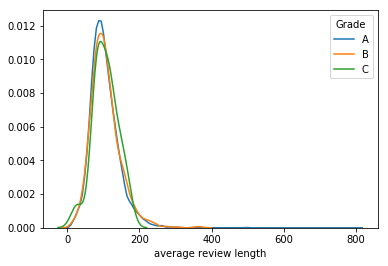

In [54]:
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='A']['avg_review_length'],label = "A")
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='B']['avg_review_length'],label = "B")
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='C']['avg_review_length'],label = "C")
plt.legend(title = 'Grade')
plt.xlabel('average review length')
plt.show()

The median of average review length is around 100, and most reviews length do not exceed 200. The distribution of average length does not vary a lot by grade.

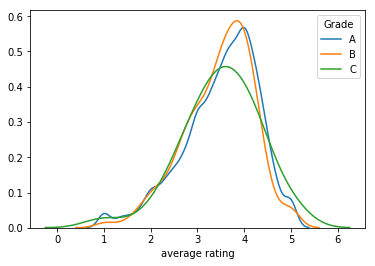

In [55]:
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='A']['avg_rating'],label = "A")
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='B']['avg_rating'],label = "B")
sns.kdeplot(data_recent_yelp_matched[data_recent_yelp_matched['GRADE']=='C']['avg_rating'],label = "C")
plt.legend(title = 'Grade')
plt.xlabel('average rating')
plt.show()

For those restaurants get grade C, its average length is likely to be lower.

Most of the yelp data we get is continuous data, such as rating, price, review_count, average review length. Draw a correlation heatmap to see if they are correlated with inspection score and violation count.

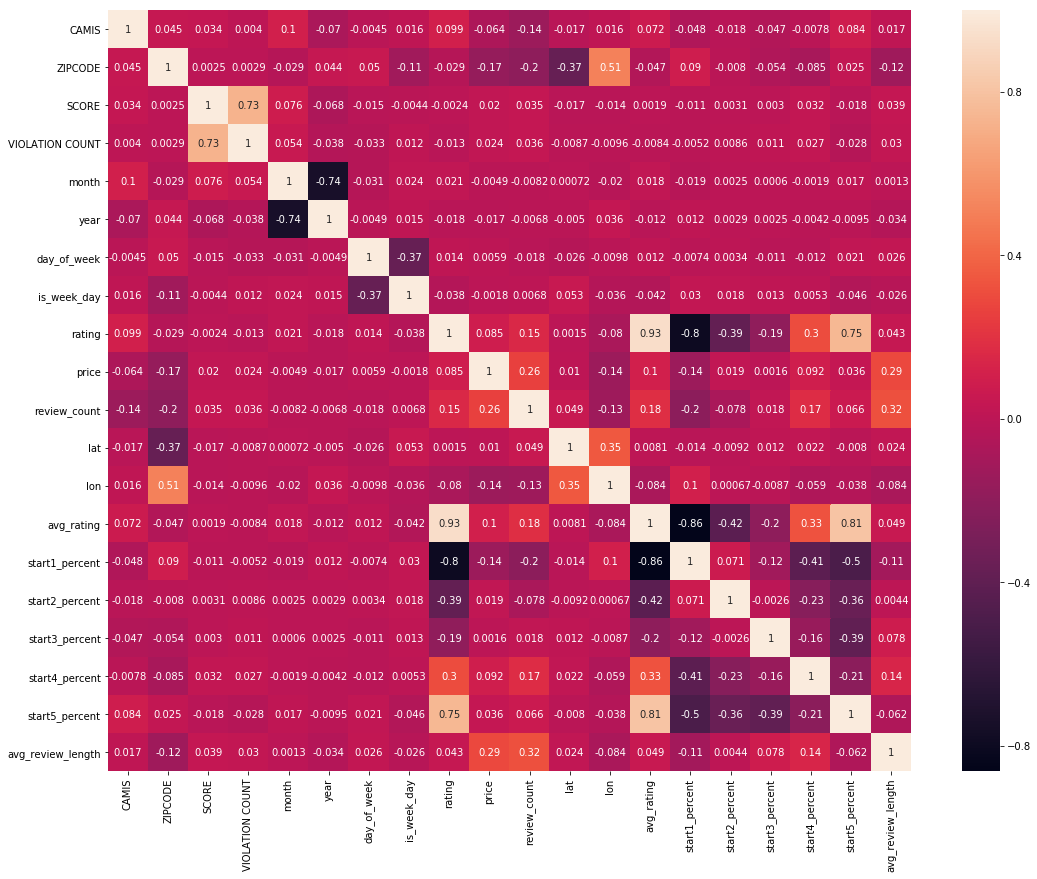

In [56]:
import seaborn as sns
corr_matrix = data_recent_yelp_matched.corr()
plt.figure(figsize = (18,14))
sns.heatmap(corr_matrix,annot=True)
plt.show()

Ignore some useless pairs (such as score and violation count), in terms of predicting score, month has the highest correlation, but it is still as low as 0.076. 

#### Target and Features Prepare

In [57]:
score = data_recent_yelp_matched['SCORE']
violation_count = data_recent_yelp_matched['VIOLATION COUNT']

#feature column
c = ['BORO', 'STREET', 'ZIPCODE',
       'CUISINE DESCRIPTION', 'city', 'category',
       'INSPECTION TYPE', 'month', 'year', 'day_of_week',
       'season', 'zip_code_yelp','is_week_day', 'rating', 'price',
       'review_count', 'avg_rating', 'start1_percent', 'start2_percent',
       'start3_percent', 'start4_percent', 'start5_percent',
       'avg_review_length'] #,'lat','lon'

features = data_recent_yelp_matched.loc[:,c]

In [58]:
from sklearn.preprocessing import LabelEncoder

def preprocess2(raw_data):
    data = raw_data.copy()
    lbl = LabelEncoder()

    data['BORO'] = lbl.fit_transform(data['BORO'])
    data['STREET'] = lbl.fit_transform(data['STREET'])
    data['ZIPCODE'] = lbl.fit_transform(data['ZIPCODE'])
    data['CUISINE DESCRIPTION'] = lbl.fit_transform(data['CUISINE DESCRIPTION'])
    data['city'] = lbl.fit_transform(data['city'])
    data['category'] = lbl.fit_transform(data['category'])
    data['INSPECTION TYPE'] = lbl.fit_transform(data['INSPECTION TYPE'])
    data['season'] = lbl.fit_transform(data['season'])
    
    data['zip_code_yelp'] = lbl.fit_transform(data['zip_code_yelp'])
    
    
    return data

features2 = preprocess2(features)

### Lasso Regression

In our data, there are some correlated features, such as star percent data and rating, so use lasso regression as it can automatically do some feature selection.

In [59]:
# First, need to do one hot encoding to deal with categorical features.
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features = [0,1,2,3,4,5,6,7,8,9,10,11])
features_ohe = ohe.fit_transform(features2)

In [60]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_ohe, score, test_size=0.3, random_state=15688)

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
print("lasso regression MSE:")
lr = LassoCV()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(mean_squared_error(y_test, pred))

lasso regression MSE:
16.412092516301534


In [62]:
print("baseline MSE:")
mean = np.mean(y_train)
pred = [mean for i in range(len(y_test))]
print(mean_squared_error(y_test, pred))

baseline MSE:
17.74640783714786


### Random Forest

In [63]:
# split on feature2, while lasso regression split on features_ohe
X_train, X_test, y_train, y_test = train_test_split(features2, score, test_size=0.3, random_state=15688)

In [64]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor 

def RandomForestCV(params, X_train, y_train, X_test,y_test,num_folds=5):
    CV = []
    folds = KFold(num_folds, shuffle=True)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    for n in params:
        fold_scores = []
        for k,(train_index,val_index) in enumerate(folds.split(X_train,y_train)):
            rf = RandomForestRegressor(n_estimators = n,random_state=15688)
            rf.fit(X_train.iloc[train_index,:],y_train[train_index])
            pred = rf.predict(X_train.iloc[val_index,:])
            fold_scores.append(mean_squared_error(y_train[val_index],pred))
            
        cross_val_score = np.mean(fold_scores)
        CV.append(cross_val_score)
    
    BestN = params[np.argmin(CV)]
    print("best n_estimator: ", str(BestN))
    bestRF = RandomForestRegressor(n_estimators = BestN,random_state=15688)
    bestRF.fit(X_train, y_train)
    pred = bestRF.predict(X_test)
    
    print(mean_squared_error(y_test, pred))

    return (BestN,bestRF)

In [65]:
print("Random Forest MSE:")
estimators = [20,50,80,100]
BestN, bestRF =  RandomForestCV(estimators, X_train, y_train, X_test, y_test)

Random Forest MSE:
best n_estimator:  100
16.67032605148648


In [66]:
# just to confirm that using the same seed, will split data in same way
print("baseline MSE:")
mean = np.mean(y_train)
pred = [mean for i in range(len(y_test))]
print(mean_squared_error(y_test, pred))

baseline MSE:
17.74640783714786


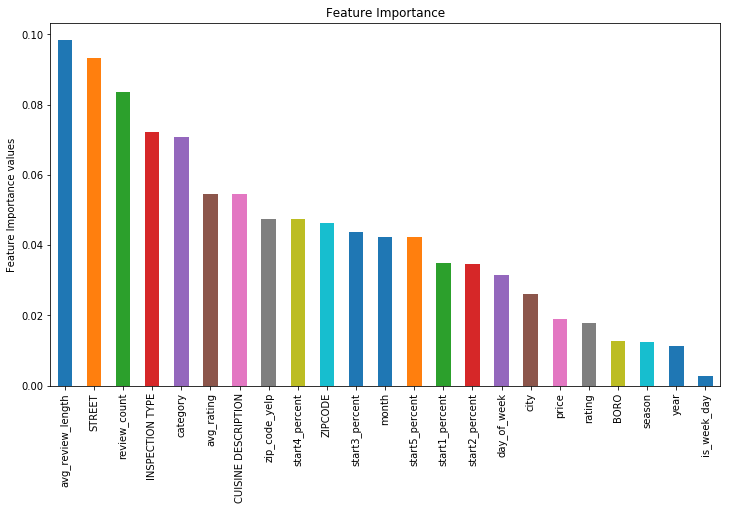

In [67]:
def plot_feature_importance(rf,X_train):
    imp_feat_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    imp_feat_rf.plot(kind='bar', title='Feature Importance', figsize=(12,8))
    plt.ylabel('Feature Importance values')
    plt.subplots_adjust(bottom=0.25)
    plt.show()
plot_feature_importance(bestRF, X_train)

Average review length, street, review count, inspection type are most useful for predicting scores. And notice that the average rating that we calculated from recent reviews is more useful than the rating score directly given from Yelp.

### Light GBM

While Random Forest uses bagged trees, Light GBM is a gradient boosted tree model. Compared with XGboost, it tends to have higher accuracy as it grows tree leaf-wise and it buckets continuous data so that it is fast. 

In [68]:
from sklearn.model_selection import KFold
import lightgbm as gbm

def lightgbmCV(X_train, y_train, X_test,y_test, leaves, depth, estimators, num_folds=5):
    grid = []
    CV = []
    folds = KFold(num_folds, shuffle=True)
    for l in leaves:
        for d in depth:
            for n in estimators:
                fold_scores = []
                for k,(train_index,val_index) in enumerate(folds.split(X_train,y_train)):
                    lgbm = gbm.LGBMRegressor(num_leaves=l, max_depth=d, n_estimators=n)
                    lgbm.fit(X_train.iloc[train_index,:],np.array(y_train)[train_index])
                    pred = lgbm.predict(X_train.iloc[val_index,:])
                    fold_scores.append(mean_squared_error(np.array(y_train)[val_index],pred))
            
                cross_val_score = np.mean(fold_scores)
                CV.append(cross_val_score)
                grid.append((l,d,n))
    
    Best = grid[np.argmin(CV)]
    print("best num_leaves: ", str(Best[0]))
    print("best max_depth: ", str(Best[1]))
    print("best n_estimators: ", str(Best[2]))
    bestlgb = gbm.LGBMRegressor(num_leaves=Best[0], max_depth=Best[1], n_estimators=Best[2])
    bestlgb.fit(X_train, y_train)
    pred = bestlgb.predict(X_test)
    
    print("best MSE: ", mean_squared_error(y_test,pred))

    return (Best,bestlgb)

In [69]:
print("Light GBM:")
leaves = [30,50,100]
depth = [6,8,10]
estimators = [20,50,100]
Best, bestlgb = lightgbmCV(X_train, y_train, X_test, y_test, leaves, depth, estimators)

Light GBM:
best num_leaves:  30
best max_depth:  6
best n_estimators:  20
best MSE:  16.15011936345389


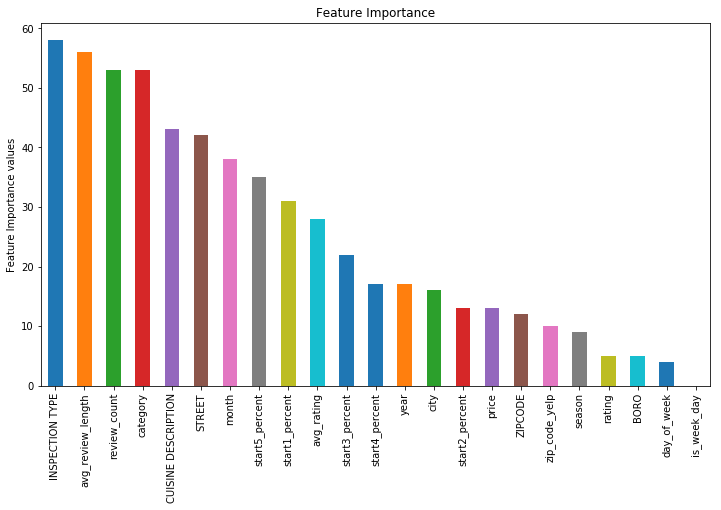

In [70]:
plot_feature_importance(bestlgb, X_train)

The feature importance is a litte bit different than that of random forest. But overall very similar, the features of top importance are: inspection type, average review length, review count and category.

So far, we do not use the review text data, but just some summary statistics. Next, do some prediction just on the text it self.

#### Use tfidf vector to represent review text.

In [71]:
reviews = data_recent_yelp_matched['PHONE1'].apply(lambda x: phone_review_info_map[x].text_all if x in phone_review_info_map.keys() else -1)
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords=nltk.corpus.stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = stopwords,max_df = 0.99, min_df = 0.01)
reviews_tfidf = tfidf.fit_transform(reviews)
reviews_tfidf

<15706x5274 sparse matrix of type '<class 'numpy.float64'>'
	with 6771104 stored elements in Compressed Sparse Row format>

### Light GBM on Review Text Data

With high dimension data, linear regression and random forest is very slow. So we simply use light GBM for text data

In [74]:
X_train,X_test,y_train,y_test = train_test_split(reviews_tfidf, score, test_size=0.3, random_state = 15688)

In [75]:
#differ from previous 1 as now X is sparse matrix instead of numpy array
def lightgbmCV(X_train, y_train, X_test,y_test, leaves, depth, estimators, num_folds=5):
    grid = []
    CV = []
    folds = KFold(num_folds, shuffle=True)
    for l in leaves:
        for d in depth:
            for n in estimators:
                fold_scores = []
                for k,(train_index,val_index) in enumerate(folds.split(X_train,y_train)):
                    lgbm = gbm.LGBMRegressor(num_leaves=l, max_depth=d, n_estimators=n)
                    lgbm.fit(X_train[train_index],np.array(y_train)[train_index])
                    pred = lgbm.predict(X_train[val_index])
                    fold_scores.append(mean_squared_error(np.array(y_train)[val_index],pred))
            
                cross_val_score = np.mean(fold_scores)
                CV.append(cross_val_score)
                grid.append((l,d,n))
    
    Best = grid[np.argmin(CV)]
    print("best num_leaves: ", str(Best[0]))
    print("best max_depth: ", str(Best[1]))
    print("best n_estimators: ", str(Best[2]))
    bestlgb = gbm.LGBMRegressor(num_leaves=Best[0], max_depth=Best[1], n_estimators=Best[2])
    bestlgb.fit(X_train, y_train)
    pred = bestlgb.predict(X_test)
    
    print("best MSE: ", mean_squared_error(y_test,pred))

    return (Best,bestlgb)

In [76]:
print("Light GBM for review text:")
leaves = [30,50]
depth = [6,8]
estimators = [20,50]
Best, bestlgb = lightgbmCV(X_train, y_train, X_test, y_test, leaves, depth, estimators)

Light GBM for review text:
best num_leaves:  50
best max_depth:  6
best n_estimators:  20
best MSE:  17.1507152297495


The tfidf vector of text data does not have much predicting power. That may due to the small data size. We only scrape the reviews from first page.

## Summary 

Light GBM achieves the best MSE, but the difference between three models are very small, and the performance of all the three models are just a little bit better than the baseline model. There are some possible explanations for the poor poerformance: 

1. Due to the limitation of the usage of Yelp API key, the individual computer power and time restriction, we only get the current business information and only partial of the reviews from Yelp, so the features are not complete and not time dependent. 

2. The Yelp data may not be that useful as we thought to be. Firstly,it is based on customers' reviews, but sometimes customers cannot find out the hygiene issues, after all they never go to see the kitchen and watch how they cook and clean equipments. Secondly, reality is more complex. The hygiene score can depend on many factors, such as weather, food source, etc. It is hard to only use Yelp data to make prediction.

3. The way we process the inspection data may not be perfect that we only consider its most recent inspection, and ignore its historical records. Also, we do not take the critical degree of the violation into account, but just weight them the same and count.

## Future Work

1. Get more Yelp data and get the time-dependent data. It is better if we match the information of restaurnats at different times with the time of the inspection date. For instance, we can parse the review post date to get review snapshot information in different times.

2. Incorporate data from more dimensions. For instance, according to the artical [here]( https://www.pbs.org/newshour/show/chicago-revamps-restaurant-inspections-by-tapping-into-social-media),features like tobacco license, burglary in the neighborhood may help. 

3. Generate more restaurnat specific features. For instance, add the historical inspection records of the restaurants. Can also categorize whether the restaurant serve alcohol, whether it is a chain restaurant, etc.

4. The inspection data is complex itself. Instead of predicting score, can also try to predict grade, violation count, or just focus on the violations that are critical.

5. Can do more work on analyzing the review text. Can try bigrams to represent it. Or use LDA to help reduce dimension and do further analysis. There are many NLP techniques.

6. Ensemble or stack different models together. For instance, can add the prediction result from the review text as a new feature.

### Reference

1. mlxtend user guide of frequent patterns: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
2. Light GBM documentation: http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api
3. An algorithm is helping Chicago health officials predict restaurant safety violations: https://www.pbs.org/newshour/show/chicago-revamps-restaurant-inspections-by-tapping-into-social-media
4. Using Yelp data to predict restaurant inspection failure: https://medium.com/@jashkina/i-used-yelp-to-predict-whether-a-restaurant-will-fail-safety-inspections-1ca5b82ef06f
